# 1. Goal

E-commerce websites often transact huge amounts of money. And whenever a huge amount of money is moved, there is a high risk of users performing fraudulent activities, e.g. using stolen credit cards, doing money laundry, etc.
The goal here is to build a machine learning model that predicts the probability that the first transaction of a new user is fraudulent.

In [140]:
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier



In [18]:
df_ip = pd.read_csv('IpAddress_to_Country.csv')

In [19]:
df = pd.read_csv('Fraud_Data.csv')

# 2. Data cleaning

In this step, we want to have an overview of the input - the column types, distribution, length, etc.

In [20]:
df.head()

,"""user_id""",signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 "user_id"        151112 non-null int64
signup_time       151112 non-null object
purchase_time     151112 non-null object
purchase_value    151112 non-null int64
device_id         151112 non-null object
source            151112 non-null object
browser           151112 non-null object
sex               151112 non-null object
age               151112 non-null int64
ip_address        151112 non-null float64
class             151112 non-null int64
dtypes: float64(1), int64(4), object(6)
memory usage: 12.7+ MB


In [91]:
# change column name of user id
df = df.rename(columns={' "user_id"':'user_id'})
df['signup_time'] = pd.to_datetime(df['signup_time'])
df['purchase_time'] = pd.to_datetime(df['purchase_time'])

In [22]:
df_ip.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [23]:
df_ip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138846 entries, 0 to 138845
Data columns (total 3 columns):
lower_bound_ip_address    138846 non-null float64
upper_bound_ip_address    138846 non-null int64
country                   138846 non-null object
dtypes: float64(1), int64(1), object(1)
memory usage: 3.2+ MB


Let's match ip address to country name and add that as a feature to our main dataframe.

In [53]:
def match_country(row):
    ip = row['ip_address']
    match = df_ip[(df_ip['lower_bound_ip_address']<ip)&(df_ip['upper_bound_ip_address']>ip)]['country']
    if (len(match) > 0):
        country.append(match.values[0])
    else:
        country.append('NA')

In [54]:
country = []
df.apply(lambda row:match_country(row),axis = 1)
df['country'] = country

In [58]:
df['country'].value_counts()[:10]

United States        58049
NA                   21966
China                12038
Japan                 7306
United Kingdom        4490
Korea Republic of     4162
Germany               3646
France                3161
Canada                2975
Brazil                2961
Name: country, dtype: int64

Sweet. Now lets make some new features based on our prior understandings of fraud:

1. time of the day (if we have the local time or dictionary to map the country names to dateutil.tz), the week and the year of the sign up and purchase time

2. the time duration between sign up and purchase

3. sharing device 

4. sharing IP

In [65]:
len(df['user_id'].unique())==len(df)

True

In [70]:
len(df['device_id'].unique())==len(df)

False

In [71]:
len(df['ip_address'].unique())==len(df)

False

This tells us we don't have duplicate records in the dataset, but some users share a device or an IP.

In [84]:
# create 2 new features
df['dupe_device'] = df['device_id'].duplicated()
df['dupe_ip'] = df['ip_address'].duplicated()

In [97]:
df['signup_day_of_week'] = df['signup_time'].apply(lambda x:x.weekday())
df['purchase_day_of_week'] = df['purchase_time'].apply(lambda x:x.weekday())
df['signup_month_of_year'] = df['signup_time'].dt.month
df['purchase_month_of_year'] = df['purchase_time'].dt.month

In [99]:
#numeric_features = ['purchase_value','age']
#label = 'class'
cat_features = ['source','browser','country','dupe_device','dupe_device','dupe_ip','signup_day_of_week',
                'purchase_day_of_week','signup_month_of_year','purchase_month_of_year']


In [104]:
# convert sex to binary values
df['sex'] = [(1 if s == 'M' else 0) for s in df['sex']]

In [106]:
# type casting all the categorical feature for one hot encoding
for f in cat_features:
    df[f] = df[f].astype('category')

In [108]:
df_ml = df.drop(['user_id','signup_time','purchase_time','device_id','ip_address'],axis = 1)

In [111]:
df_ml = pd.get_dummies(df_ml)

df_ml is rather sparse because of all the categorical data. Let's move on with it for now. We can use LASSO, vif or XGBoost later on.

In [125]:
# prepare train, test and scale the data
y = df_ml['class']
X = df_ml.drop('class', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [129]:
y.value_counts()/len(y)

0    0.906354
1    0.093646
Name: class, dtype: float64

As we would expect for fraudulent data, we only have less than 10% positive class. This means we should look beyond accuracy rate in model evaluation.

In [126]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


precision:  0.9854991634132738
recall:  0.489202657807309


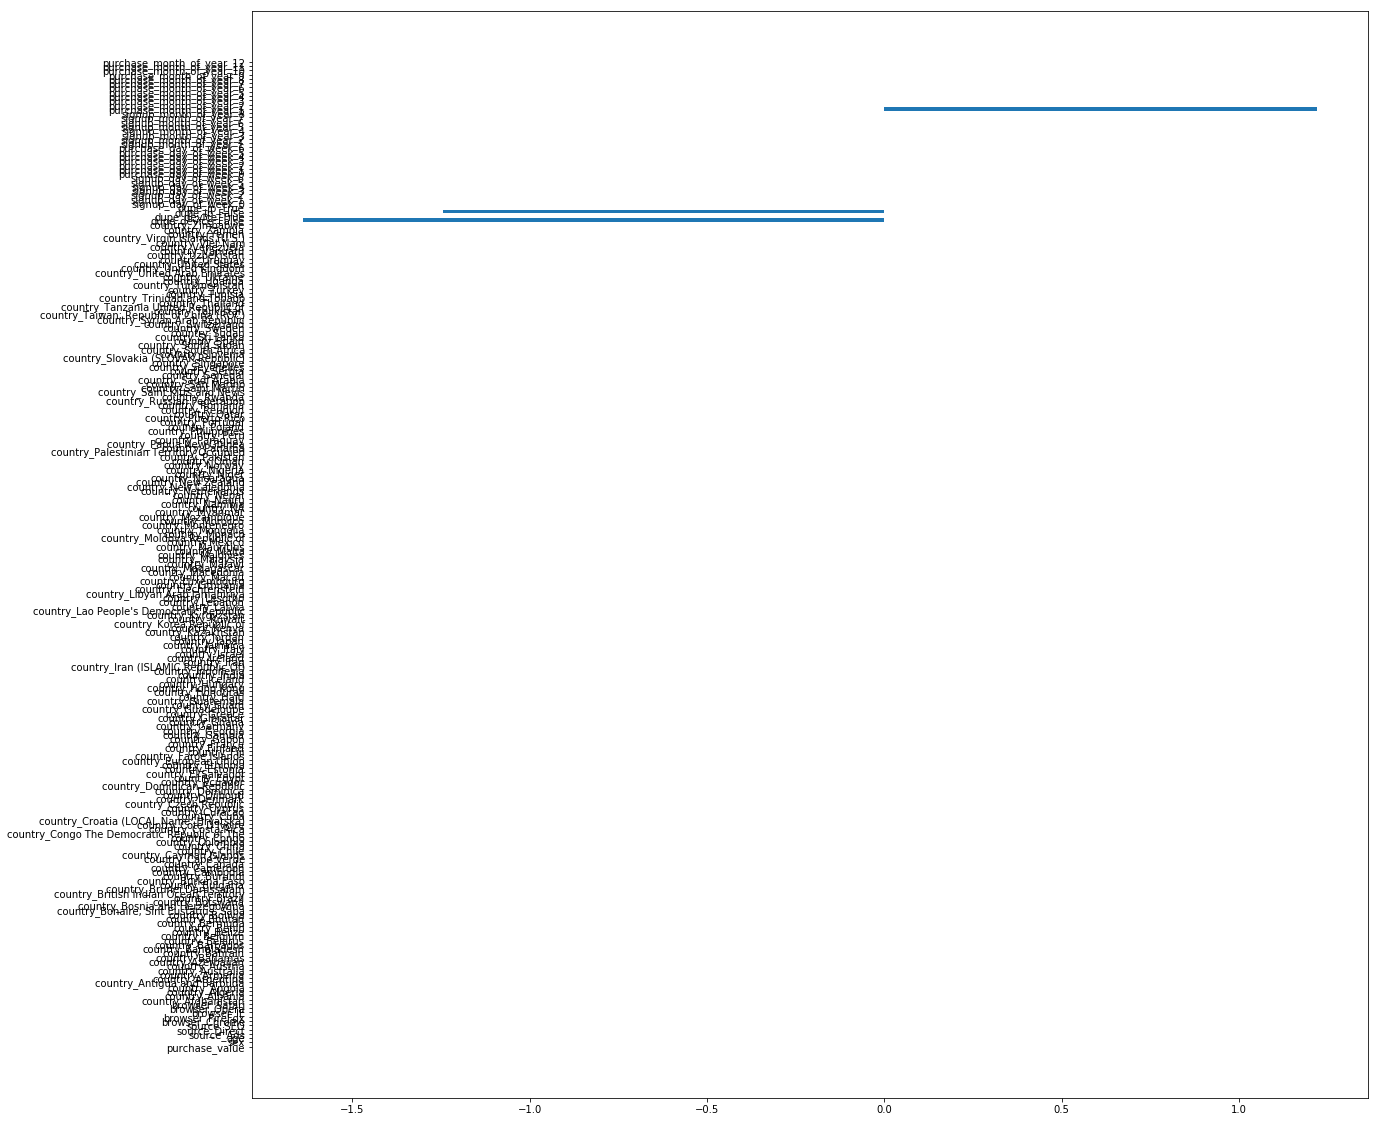

dupe_device_False         -1.6403488881264956
dupe_ip_False             -1.2453783228868305
purchase_month_of_year_1  1.2205264057995147
purchase_value            0.0
country_Portugal          0.0
country_Puerto Rico       0.0
country_Qatar             0.0
country_Reunion           0.0
country_Romania           0.0
country_Russian Federation 0.0


In [149]:

logreg = LogisticRegressionCV(scoring = 'f1',max_iter=1000,solver = 'liblinear',penalty = 'l1')
logreg.fit(X_train_scaled, y_train)
y_pred = logreg.predict(X_test_scaled)
print ("precision: ", precision_score(y_test,y_pred))
print ("recall: ", recall_score(y_test,y_pred))

coef = logreg.coef_[0]
plt.figure(figsize=(20,20))
plt.barh(y=X.columns,width = coef)
plt.show()

top_10 = np.argsort(-np.absolute(coef))[:10]
for i in top_10:
    print ("%-25s %s" % ((X.columns[i], coef[i])))

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


precision:  0.9243609806990088
recall:  0.49058693244739754


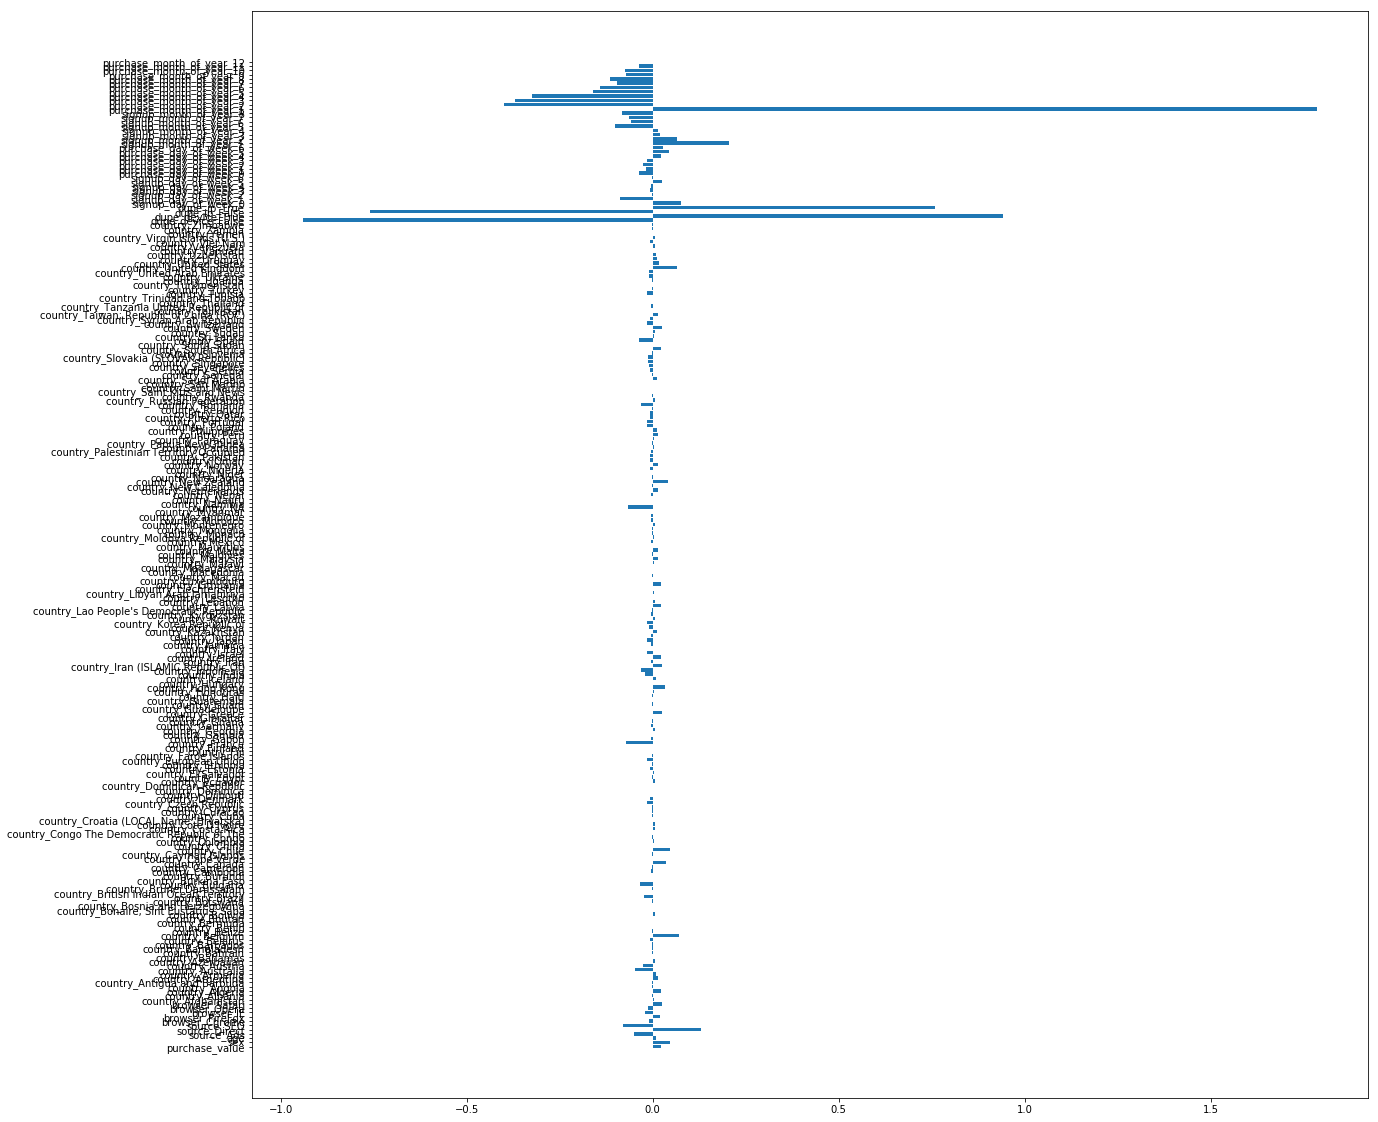

purchase_month_of_year_1  1.7865054173788626
dupe_device_False         -0.9414435308478749
dupe_device_True          0.941377620308098
dupe_ip_False             -0.759291927927996
dupe_ip_True              0.7592260173882162
purchase_month_of_year_2  -0.3990190722962477
purchase_month_of_year_3  -0.36900771588633513
purchase_month_of_year_4  -0.32423417736207766
signup_month_of_year_1    0.20443066362872547
purchase_month_of_year_5  -0.16121100778798614


In [150]:
logreg = LogisticRegressionCV(scoring = 'recall',max_iter=1000)
logreg.fit(X_train_scaled, y_train)
y_pred = logreg.predict(X_test_scaled)
print ("precision: ", precision_score(y_test,y_pred))
print ("recall: ", recall_score(y_test,y_pred))
coef = logreg.coef_[0]
plt.figure(figsize=(20,20))
plt.barh(y=X.columns,width = coef)
plt.show()


top_10 = np.argsort(-np.absolute(coef))[:10]
for i in top_10:
    print ("%-25s %s" % ((X.columns[i], coef[i])))

In [139]:
rfc = RandomForestClassifier(n_estimators = 100)
rfc.fit(X_train_scaled, y_train)
y_pred = rfc.predict(X_test_scaled)
print ("precision: ", precision_score(y_test,y_pred))
print ("recall: ", recall_score(y_test,y_pred))

precision:  0.9602302459445317
recall:  0.5080287929125138


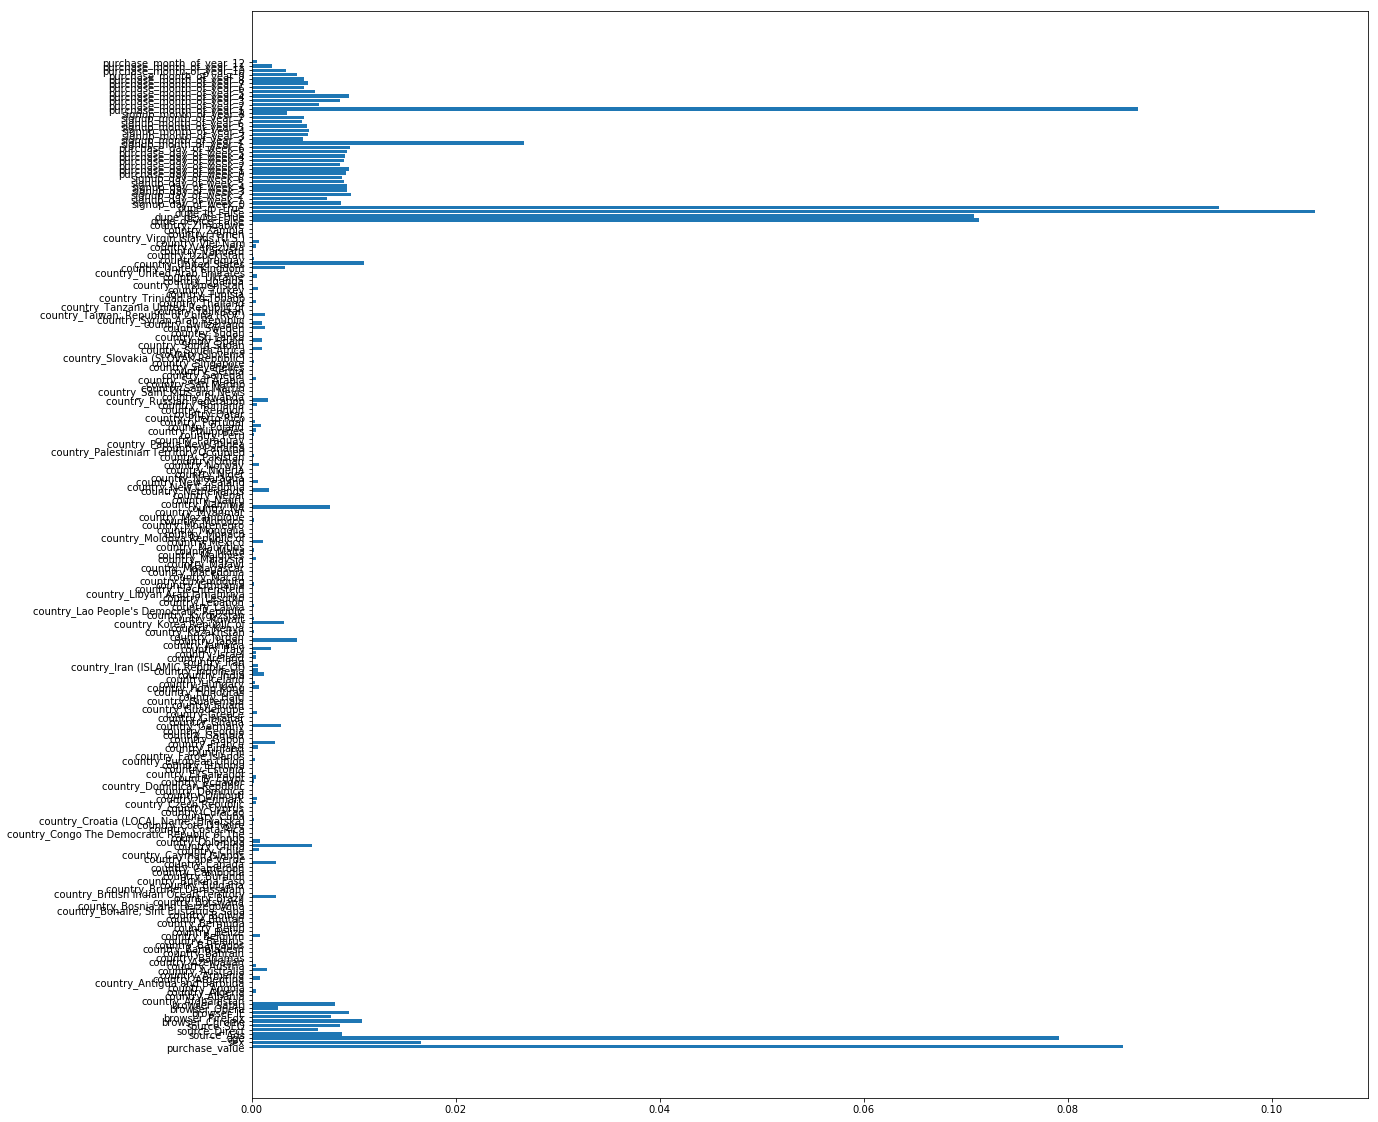

dupe_ip_False             0.1042203229913405
dupe_ip_True              0.09481279840591421
purchase_month_of_year_1  0.08685599647008618
purchase_value            0.0854101243446024
age                       0.07914781043726228
dupe_device_False         0.0713420706772331
dupe_device_True          0.07084703821486628
signup_month_of_year_1    0.026663008830937054
sex                       0.016546392684491065
country_United States     0.011040814607955512


In [153]:
coef = rfc.feature_importances_
plt.figure(figsize=(20,20))
plt.barh(y=X.columns,width = coef)
plt.show()


top_10 = np.argsort(-np.absolute(coef))[:10]
for i in top_10:
    print ("%-25s %s" % ((X.columns[i], coef[i])))

We see that the performance is similar across different models - precision is high but the recall is around 50%. This means the model correctly predicted fraudulent activities - over 90% of the predictions are correct. However, it was only able to find 50% of the fraudulent activities. One explanation to this result is our model is able to find the typical frauds (such as bots) but not able to differentiate the rest. 
In this We could look further into the data and tweak the model to improve the recall score